# 양돈 모돈 데이터 파일 전처리 및 시각화

## 2023년 기준 양돈 모돈 데이터 전처리

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 데이터 불러오기
file_path = "../../data/pigmom_data/2023 양돈 모돈 데이터.csv"
df = pd.read_csv(file_path)

In [3]:
# 날짜 변환
df['분만일'] = pd.to_datetime(df['분만일'], format='%Y%m%d', errors='coerce')

# 연도, 월, 계절 컬럼 추가
df['연도'] = df['분만일'].dt.year
df['월'] = df['분만일'].dt.month

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   농장아이디      1332 non-null   object        
 1   개체 구별 번호   1332 non-null   int64         
 2   산차         1332 non-null   int64         
 3   교배지수       1332 non-null   int64         
 4   경과일        1332 non-null   int64         
 5   교배일        1332 non-null   int64         
 6   임신 사고기간    0 non-null      float64       
 7   임신 사고 원인   0 non-null      float64       
 8   임신 기간      1332 non-null   int64         
 9   분만일        1332 non-null   datetime64[ns]
 10  총산자수       1332 non-null   int64         
 11  미라         1332 non-null   int64         
 12  사산         1332 non-null   int64         
 13  실산자수       1332 non-null   int64         
 14  생시도태두수     259 non-null    float64       
 15  양자전입두수     259 non-null    float64       
 16  양자전출두수     259 non-null    float64       


In [ ]:
df

In [6]:
# '실산자수', '이유두수' 결측 제거
df_filtered = df.dropna(subset=['실산자수', '이유두수'])

In [7]:
# 계절 매핑
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['계절'] = df['월'].apply(get_season)

In [ ]:
df

In [9]:
# 분석 대상 컬럼 중 일부 NaN 제거
df_filtered = df.dropna(subset=['실산자수', '이유두수'])

# 주차 정보 추가 (연도-주차 조합 문자열로 생성)
df_filtered['주차'] = df_filtered['분만일'].dt.to_period('W').apply(lambda r: r.start_time)

# 주 단위 평균 계산
weekly_avg = df_filtered.groupby('주차')[['실산자수', '이유두수']].mean().reset_index()

# 산차별 실산자수/이유두수 평균
by_parity = df_filtered.groupby('산차')[['실산자수', '이유두수']].mean().reset_index()

# 월별 실산자수/이유두수 평균
by_month = df_filtered.groupby('월')[['실산자수', '이유두수']].mean().reset_index()

# 계절별 실산자수/이유두수 평균
by_season = df_filtered.groupby('계절')[['실산자수', '이유두수']].mean().reset_index()

# 계절 순서 재정렬: 봄 → 여름 → 가을 → 겨울
season_order = ['겨울', '봄', '여름', '가을']
by_season_sorted = by_season.set_index('계절').loc[season_order].reset_index()

# 일자별 평균 실산자수 및 이유두수 계산
daily_avg = df_filtered.groupby('분만일')[['실산자수', '이유두수']].mean().reset_index()

/tmp/ipykernel_21270/770189048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['주차'] = df_filtered['분만일'].dt.to_period('W').apply(lambda r: r.start_time)


In [ ]:
daily_avg

In [11]:
def plot_grouped_data(df, x, y_list, title):
    for y in y_list:
        plt.plot(df[x], df[y], marker='.', label=y)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel('두수')
    plt.legend()
    plt.grid(True)
    plt.show()

## Line graph

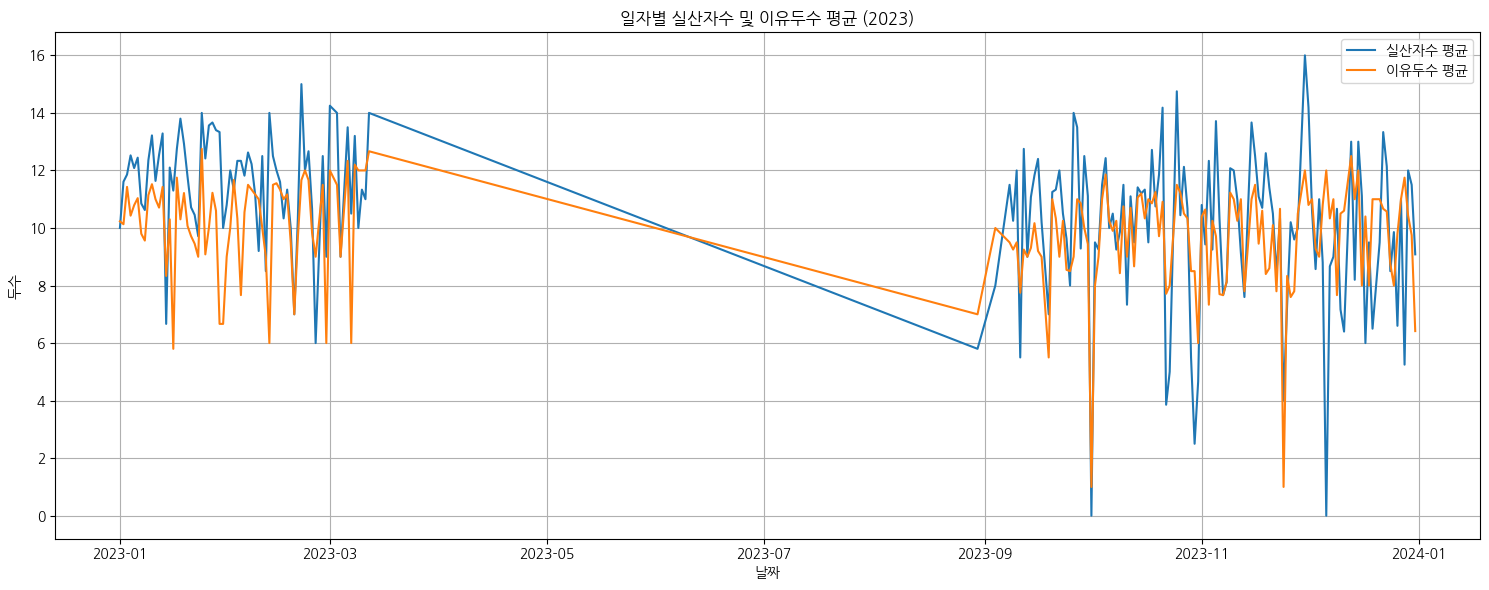

In [12]:
# 시각화
plt.figure(figsize=(15, 6))
plt.plot(daily_avg['분만일'], daily_avg['실산자수'], label='실산자수 평균')
plt.plot(daily_avg['분만일'], daily_avg['이유두수'], label='이유두수 평균')
plt.title('일자별 실산자수 및 이유두수 평균 (2023)')
plt.xlabel('날짜')
plt.ylabel('두수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### season line(Rough Graph)

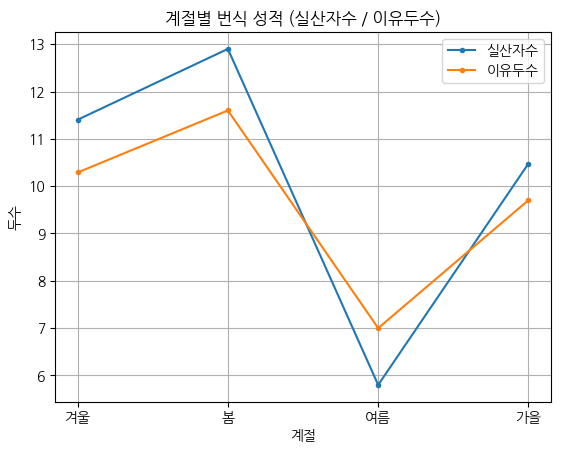

In [13]:
plot_grouped_data(by_season_sorted, '계절', ['실산자수', '이유두수'], '계절별 번식 성적 (실산자수 / 이유두수)')

### Reproductive Performance By Parity

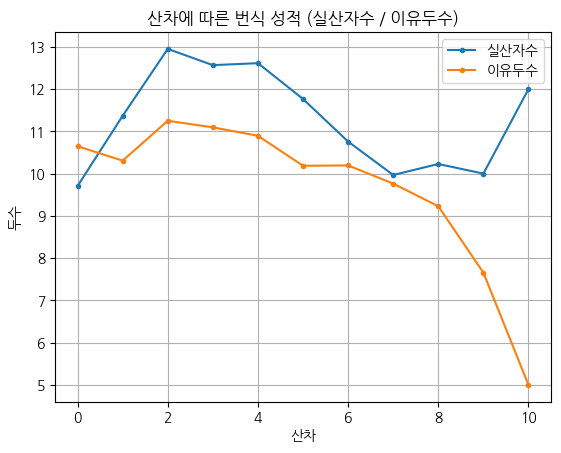

In [14]:
# 시각화 출력
plot_grouped_data(by_parity, '산차', ['실산자수', '이유두수'], '산차에 따른 번식 성적 (실산자수 / 이유두수)')

## Bar graph

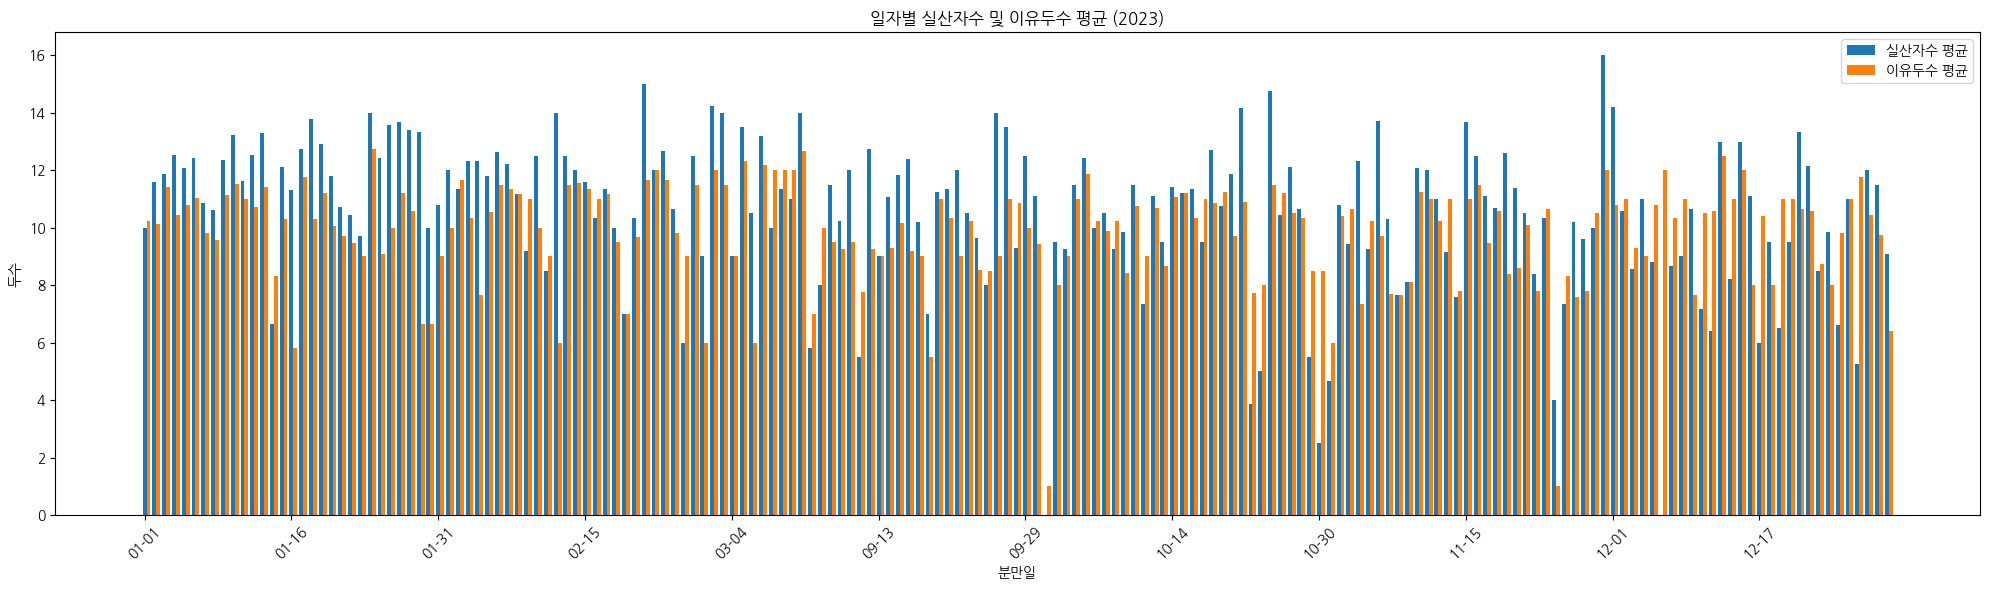

In [15]:
# 시각화: 막대그래프
plt.figure(figsize=(20, 6))
bar_width = 0.4
x = range(len(daily_avg))

plt.bar(x, daily_avg['실산자수'], width=bar_width, label='실산자수 평균')
plt.bar([i + bar_width for i in x], daily_avg['이유두수'], width=bar_width, label='이유두수 평균')

# x축 날짜 라벨 설정 (너무 많으니까 15일 단위로 표시)
plt.xticks(
    ticks=[i for i in x if i % 15 == 0],
    labels=[date.strftime('%m-%d') for i, date in enumerate(daily_avg['분만일']) if i % 15 == 0],
    rotation=45
)

plt.xlabel('분만일')
plt.ylabel('두수')
plt.title('일자별 실산자수 및 이유두수 평균 (2023)')
plt.legend()
plt.tight_layout()
plt.show()

## Scatter Graph

### Daily Graph

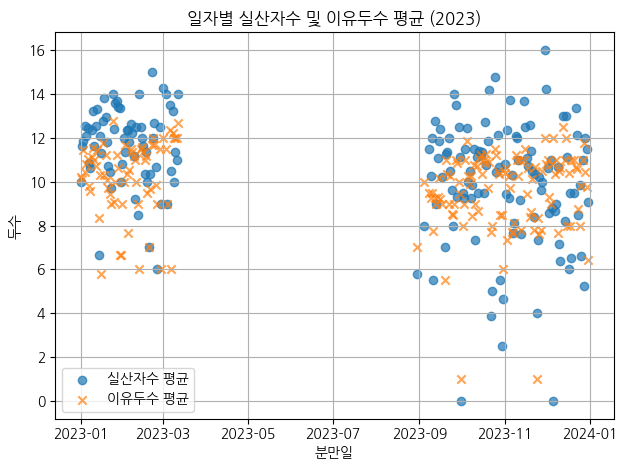

In [16]:
plt.figure()
plt.scatter(daily_avg['분만일'], daily_avg['실산자수'], label='실산자수 평균', alpha=0.7, marker='o')
plt.scatter(daily_avg['분만일'], daily_avg['이유두수'], label='이유두수 평균', alpha=0.7, marker='x')
plt.title('일자별 실산자수 및 이유두수 평균 (2023)')
plt.xlabel('분만일')
plt.ylabel('두수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Week Graph

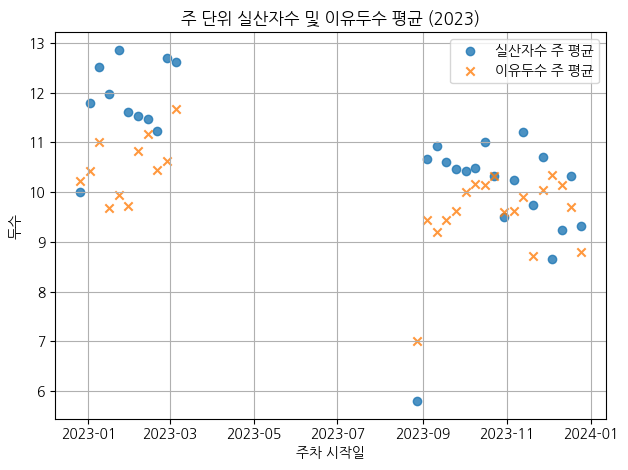

In [17]:
# 시각화
plt.figure()

plt.scatter(weekly_avg['주차'], weekly_avg['실산자수'], label='실산자수 주 평균', marker='o', alpha=0.8)
plt.scatter(weekly_avg['주차'], weekly_avg['이유두수'], label='이유두수 주 평균', marker='x', alpha=0.8)

plt.title('주 단위 실산자수 및 이유두수 평균 (2023)')
plt.xlabel('주차 시작일')
plt.ylabel('두수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 시각화로서 Scatter Graph가 최적으로 판단

## 2012~2021년 양돈 모돈 데이터 전처리

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 데이터 불러오기
file_path = "../../data/pigmom_data/combined2_data.csv"
df_all = pd.read_csv(file_path, low_memory = False)

In [ ]:
df_all

In [113]:
df_all = df_all[df_all['실산자수']>=df_all['이유두수']]

In [114]:
df_all.loc[:, '분만일'] = pd.to_datetime(df_all['분만일'], format='%Y%m%d', errors='coerce')

/tmp/ipykernel_21270/826815817.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2015-05-09 00:00:00', '2015-09-22 00:00:00', '2015-10-17 00:00:00',
 '2015-05-10 00:00:00', '2015-11-18 00:00:00', '2015-06-05 00:00:00',
 '2015-06-05 00:00:00', '2015-05-13 00:00:00', '2015-10-22 00:00:00',
 '2015-01-07 00:00:00',
 ...
 '2012-01-12 00:00:00', '2012-06-17 00:00:00', '2012-05-11 00:00:00',
 '2012-09-28 00:00:00', '2012-12-06 00:00:00', '2012-12-01 00:00:00',
 '2012-04-09 00:00:00', '2012-08-27 00:00:00', '2012-10-08 00:00:00',
 '2012-08-20 00:00:00']
Length: 82471, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_all.loc[:, '분만일'] = pd.to_datetime(df_all['분만일'], format='%Y%m%d', errors='coerce')


In [115]:
# 유효한 데이터만 필터링
df_filtered_all = df_all.dropna(subset=['실산자수', '이유두수'])
# df_filtered = df_filtered[df_filtered['분만일'].notnull()]

In [116]:
# 일자별 평균 실산자수 및 이유두수 계산
daily_avg_all = df_filtered_all.groupby('분만일')[['실산자수', '이유두수']].mean().reset_index()

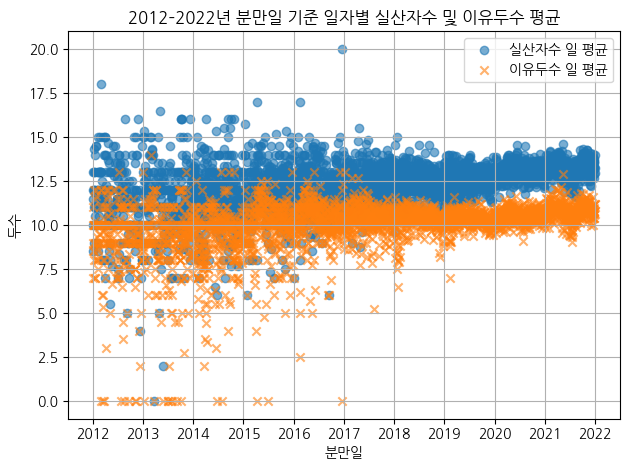

In [117]:
# 시각화
plt.figure()

plt.scatter(daily_avg_all['분만일'], daily_avg_all['실산자수'], label='실산자수 일 평균', alpha=0.6, marker='o')
plt.scatter(daily_avg_all['분만일'], daily_avg_all['이유두수'], label='이유두수 일 평균', alpha=0.6, marker='x')

plt.title('2012–2022년 분만일 기준 일자별 실산자수 및 이유두수 평균')
plt.xlabel('분만일')
plt.ylabel('두수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

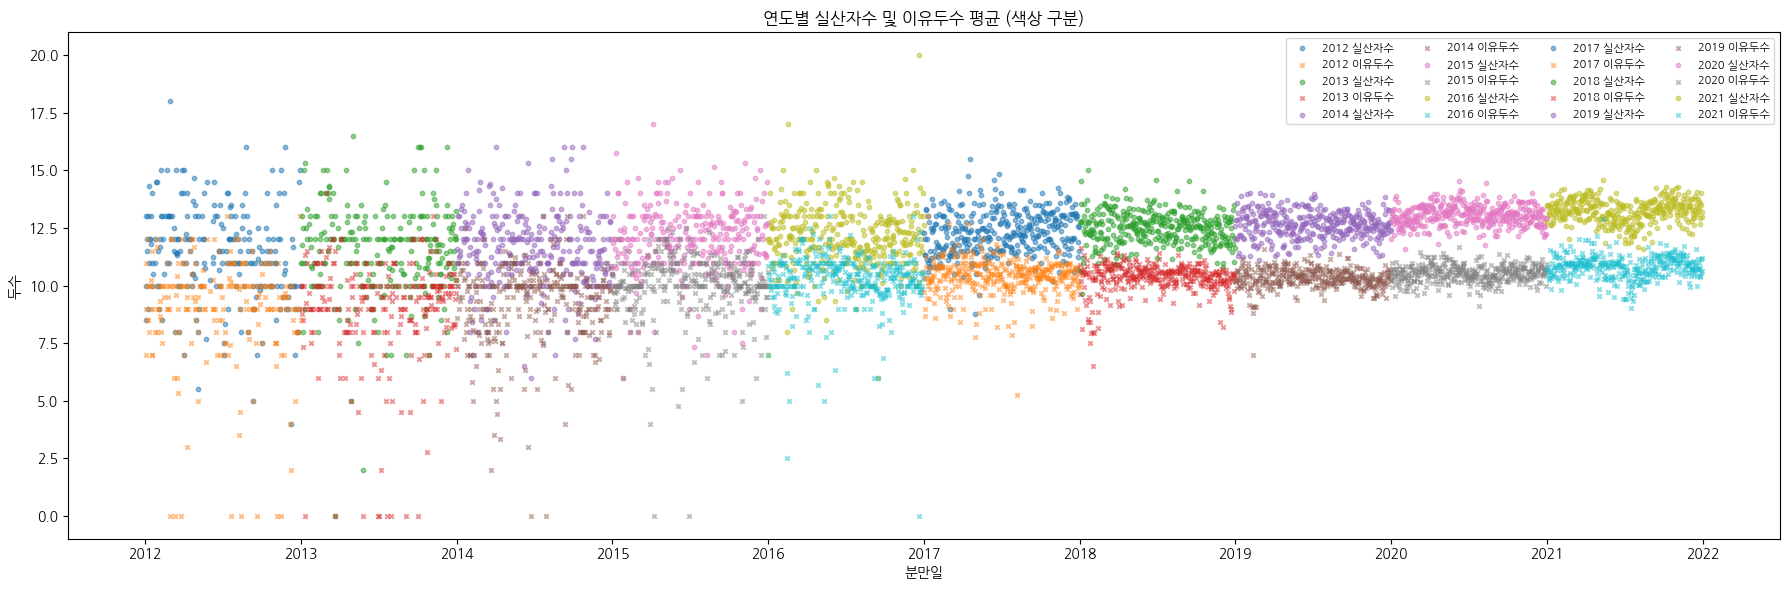

In [119]:
# 연도 컬럼 추가 (혹시 안 되어 있으면)
daily_avg_all['연도'] = daily_avg_all['분만일'].dt.year

# 시각화
plt.figure(figsize=(18, 6))

for year in sorted(daily_avg_all['연도'].unique()):
    subset = daily_avg_all[daily_avg_all['연도'] == year]
    
    # 실산자수 - 원형 마커
    plt.scatter(subset['분만일'], subset['실산자수'], alpha=0.5, s=10, label=f'{year} 실산자수', marker='o')
    
    # 이유두수 - X 마커
    plt.scatter(subset['분만일'], subset['이유두수'], alpha=0.5, s=10, label=f'{year} 이유두수', marker='x')

plt.title('연도별 실산자수 및 이유두수 평균 (색상 구분)')
plt.xlabel('분만일')
plt.ylabel('두수')
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

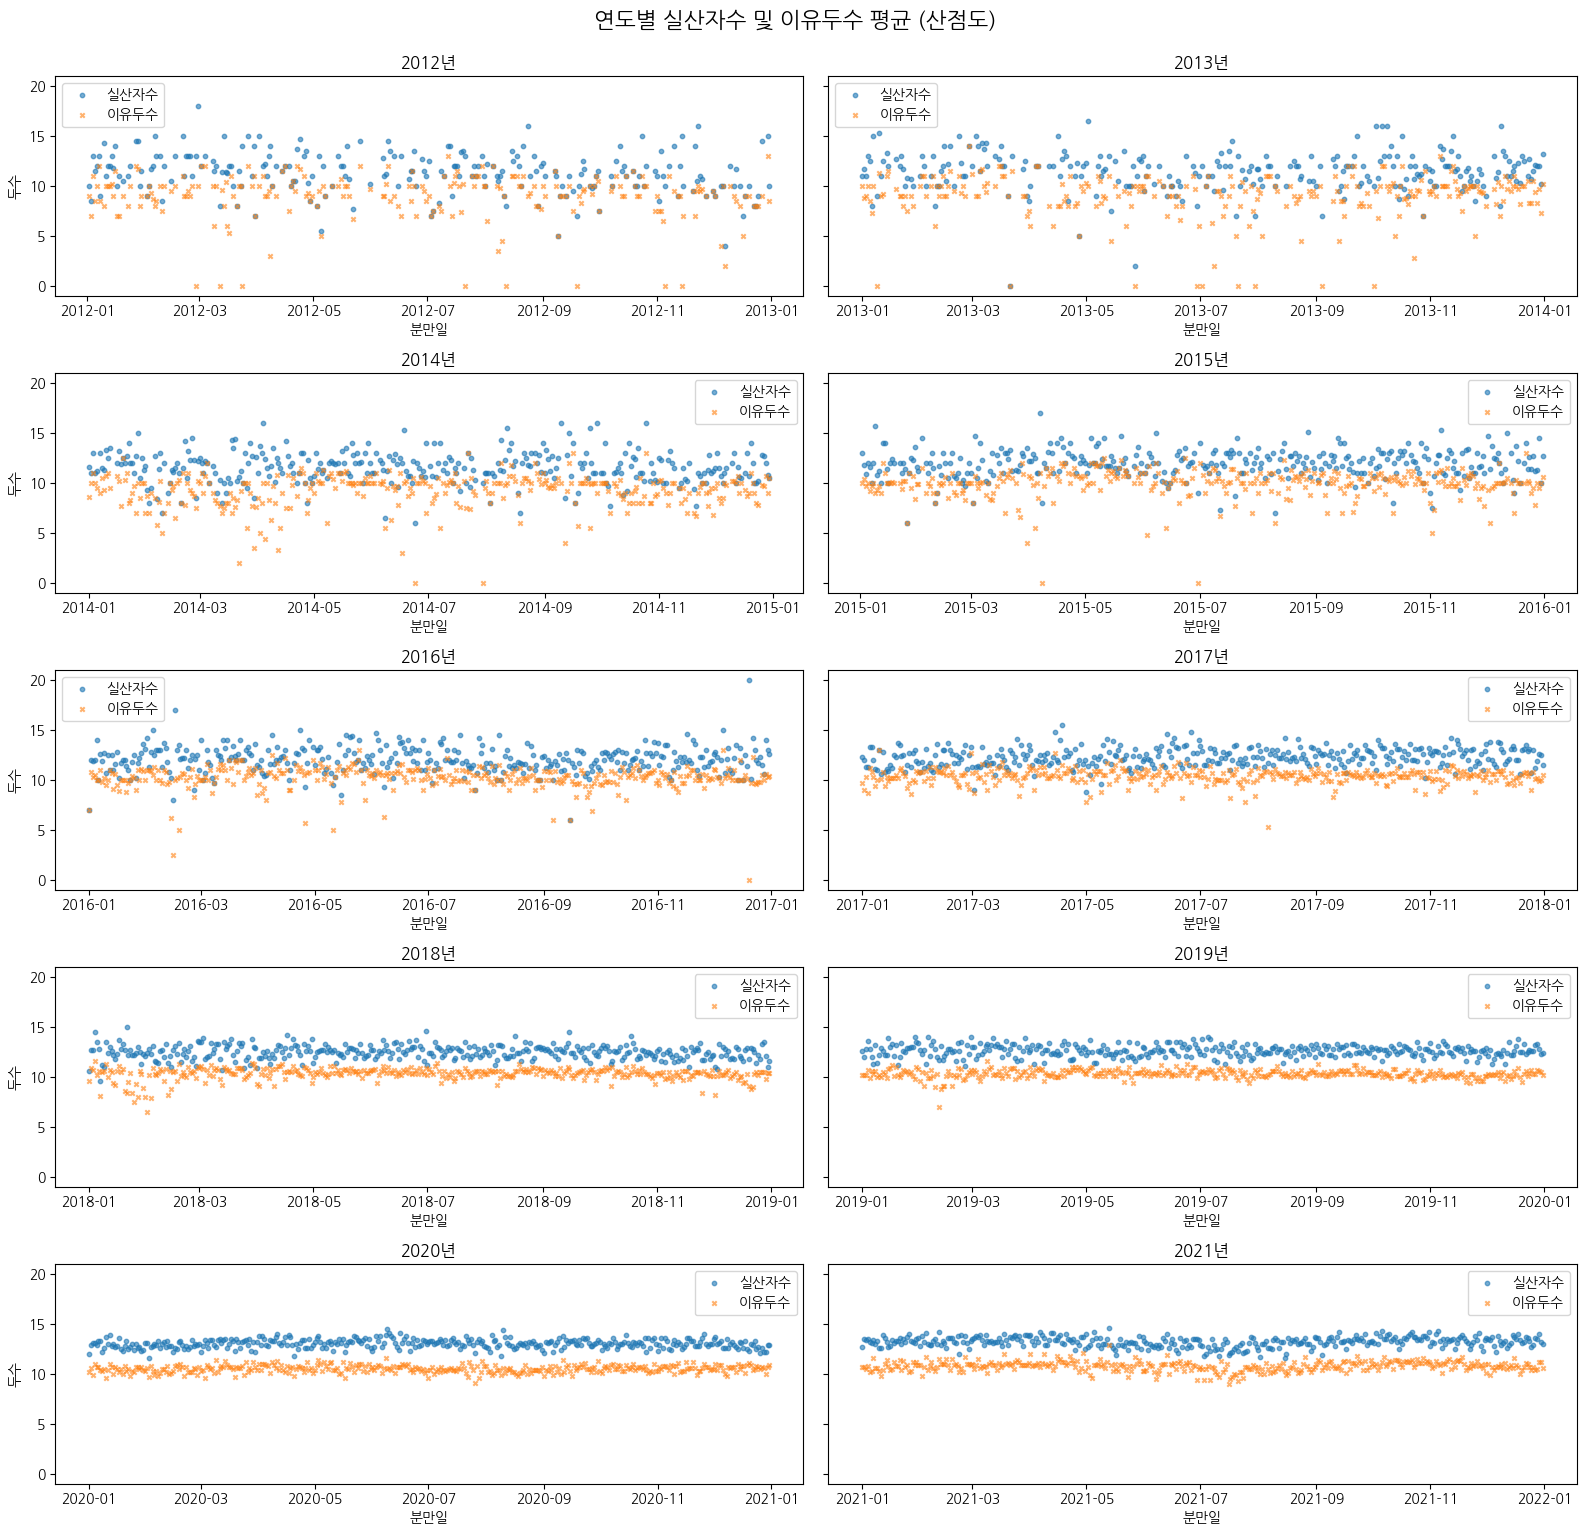

In [120]:
# 사용할 연도 리스트
years = sorted(daily_avg_all['연도'].unique())
n_years = len(years)

# subplot 레이아웃 계산 (2열 기준)
ncols = 2
nrows = (n_years + 1) // ncols  # 전체 연도 수에 맞게 행 개수 계산

# 시각화
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 3), sharey=True)
axes = axes.flatten()  # 2차원 → 1차원 배열로 변환

for i, year in enumerate(years):
    ax = axes[i]
    subset = daily_avg_all[daily_avg_all['연도'] == year]

    ax.scatter(subset['분만일'], subset['실산자수'], label='실산자수', alpha=0.6, s=10, marker='o')
    ax.scatter(subset['분만일'], subset['이유두수'], label='이유두수', alpha=0.6, s=10, marker='x')

    ax.set_title(f'{year}년')
    ax.set_xlabel('분만일')
    if i % ncols == 0:
        ax.set_ylabel('두수')
    ax.legend()

plt.tight_layout()
plt.suptitle('연도별 실산자수 및 이유두수 평균 (산점도)', fontsize=16, y=1.02)
plt.show()

### 2022년 이전 데이터의 실산자수와 이유두수의 차이(손실률)

In [125]:
# 실산자수 대비 이유두수 손실률 계산 (%)
df_all = df_all[df_all['실산자수'] > 0]  # 0으로 나누는 거 방지
df_all['손실률(%)'] = ((df_all['실산자수'] - df_all['이유두수']) / df_all['실산자수']) * 100

# 결과 미리보기
df_all[['분만일', '실산자수', '이유두수', '손실률(%)']].head()

,분만일,실산자수,이유두수,손실률(%)
0,2015-05-09,14,11.0,21.428571
1,2015-09-22,14,12.0,14.285714
3,2015-10-17,14,10.0,28.571429
4,2015-05-10,12,12.0,0.000000
5,2015-11-18,13,10.0,23.076923


In [124]:
# 필요한 경우, 합친 데이터를 CSV 파일로 저장할 수 있습니다.
df_all.to_csv("../../data/pigmom_data/prophet_data.csv", index=False)